# Customer Churn Prediction
### oleh: Hafiz Ma'ruf, S.Kom
#### Penjelasan lebih lengkap di link https://medium.com/@hafizmrf3/penerapan-data-science-pada-marketing-customer-churn-prediction-python-de43eed149a4 

### Import library yang dibutuhkan 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

### Load dataset yang digunakan 

In [2]:
df_load = pd.read_csv('telco_dataset.csv')
#Tampilkan bentuk dari dataset
print(df_load.shape)
#Tampilkan 5 data teratas
print(df_load.head())
#Tampilkan jumlah ID yang unik
print(df_load.customerID.nunique())

(6950, 13)
   UpdatedAt   customerID  gender SeniorCitizen Partner  tenure PhoneService  \
0     202006  45759018157  Female            No     Yes       1           No   
1     202006  45315483266    Male            No     Yes      60          Yes   
2     202006  45236961615    Male            No      No       5          Yes   
3     202006  45929827382  Female            No     Yes      72          Yes   
4     202006  45305082233  Female            No     Yes      56          Yes   

  StreamingTV InternetService PaperlessBilling  MonthlyCharges  TotalCharges  \
0          No             Yes              Yes           29.85         29.85   
1          No              No              Yes           20.50       1198.80   
2         Yes             Yes               No          104.10        541.90   
3         Yes             Yes              Yes          115.50       8312.75   
4         Yes             Yes               No           81.25       4620.40   

  Churn  
0    No  
1    No

### Exploratory Data Analysis

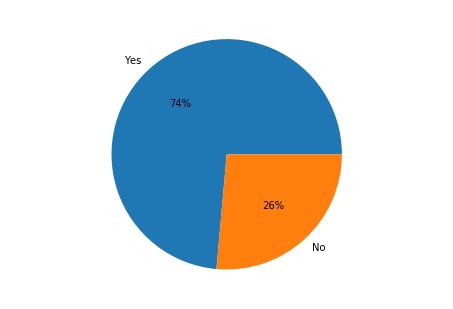

In [3]:
#memvisualisasi persentase Churn pada dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Yes','No']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

#### a. Exploratory Data Analysis pada Variabel Numerik

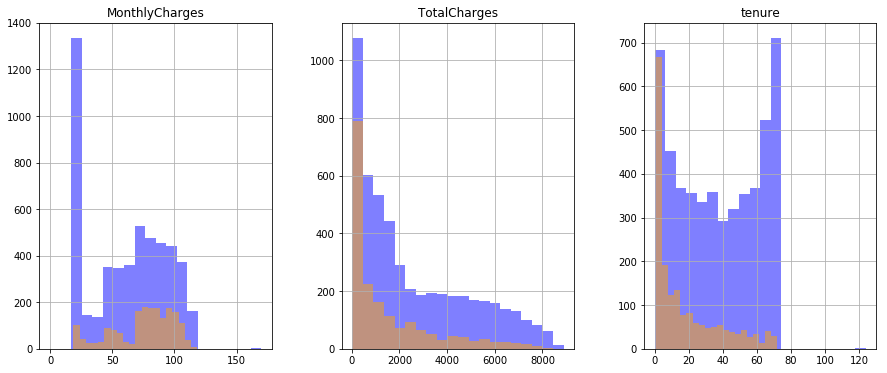

In [4]:
#membuat distribution diagram untuk 3 variabel numerik berikut 
numerical_features = ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
#gunakan code berikut ini untuk memplot 2 lapisan untuk membedakan mana yang Churn (Orange) atau Tidak (Blue) 
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

#### b. Exploratory Data Analysis pada Variabel Kategorikal

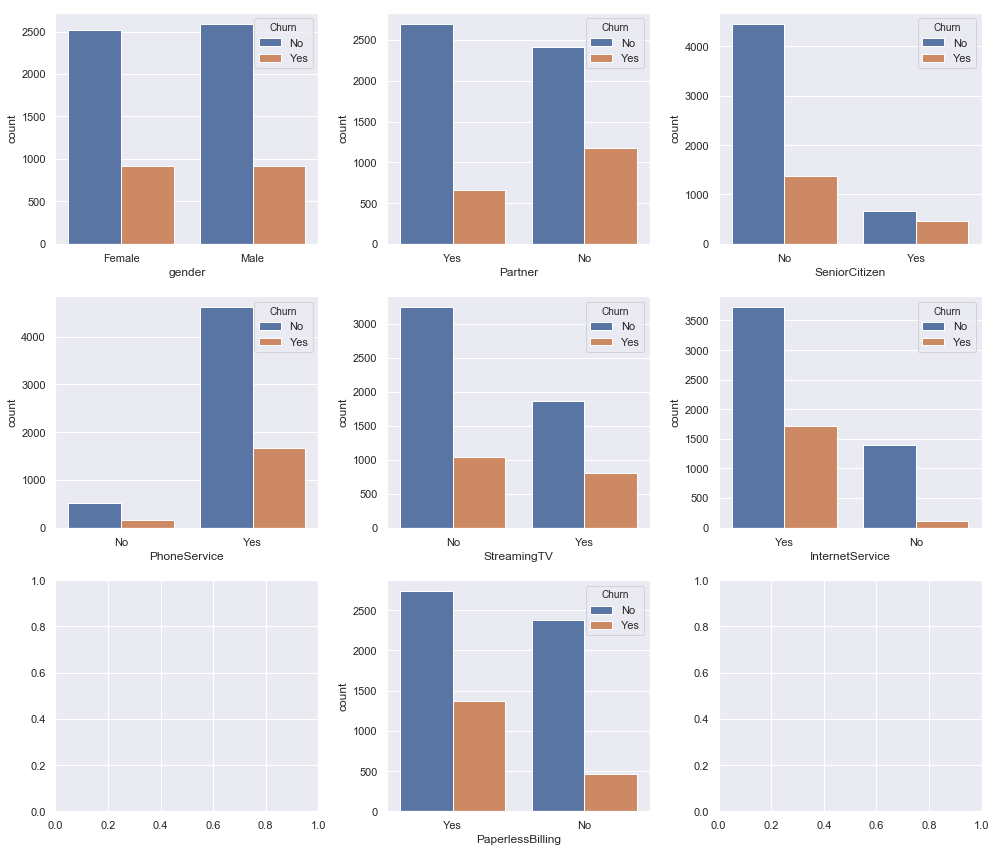

In [5]:
sns.set(style='darkgrid')
# memplot data dengan subplot ukuran 3x3
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
# menampilkan data berdasarkan variabel-variabel kategorikal yang ada
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

### Preprocessing Data

#### a. Menghapus variabel-variabel yang tidak dibutuhkan (unnecessary variables) untuk pemodelan

In [6]:
# hapus variabel customerID dan UpdatedAt dari dataset
cleaned_df = df_load.drop(['customerID', 'UpdatedAt'], axis=1)
print(cleaned_df.head())

   gender SeniorCitizen Partner  tenure PhoneService StreamingTV  \
0  Female            No     Yes       1           No          No   
1    Male            No     Yes      60          Yes          No   
2    Male            No      No       5          Yes         Yes   
3  Female            No     Yes      72          Yes         Yes   
4  Female            No     Yes      56          Yes         Yes   

  InternetService PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0             Yes              Yes           29.85         29.85    No  
1              No              Yes           20.50       1198.80    No  
2             Yes               No          104.10        541.90   Yes  
3             Yes              Yes          115.50       8312.75    No  
4             Yes               No           81.25       4620.40    No  


#### b. Label Encoding data

In [7]:
from sklearn.preprocessing import LabelEncoder
#konversi semua variabel tipe non-numerikal ke tipe numerikal  
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number: continue
    #terapkan encoding pada tiap variabel non-numerikal
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df)

      gender  SeniorCitizen  Partner  tenure  PhoneService  StreamingTV  \
0          0              0        1       1             0            0   
1          1              0        1      60             1            0   
2          1              0        0       5             1            1   
3          0              0        1      72             1            1   
4          0              0        1      56             1            1   
...      ...            ...      ...     ...           ...          ...   
6945       1              0        0       1             1            0   
6946       0              1        0       1             1            0   
6947       0              0        0       1             1            1   
6948       0              0        1      72             1            1   
6949       1              0        0      64             1            0   

      InternetService  PaperlessBilling  MonthlyCharges  TotalCharges  Churn  
0                   

#### C. Splitting data (Memisahkan data train dan data test)

In [8]:
from sklearn.model_selection import train_test_split
# Predictor -> X dan target -> y
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']
# Splitting data train dan data test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print deskripsi
print('Jumlah baris dan kolom dari x_train adalah: ', x_train.shape, ', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Persentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', x_test.shape, ', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Persentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah:  (4865, 10) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Persentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 10) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Persentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


### Pemodelan Machine Learning untuk Prediksi dan Klasifikasi

#### a. Pemodelan dengan metode Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(x_train, y_train)
print('Model Logistic Regression yang terbentuk adalah: \n',log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\hafizmrf3\Anaconda3\envs\envDL_TF1_14\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
#Menampilkan hasil training dengan confusion matrix
from sklearn.metrics import classification_report
# Predict
y_train_pred = log_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3575
           1       0.65      0.50      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.72      4865
weighted avg       0.79      0.80      0.79      4865



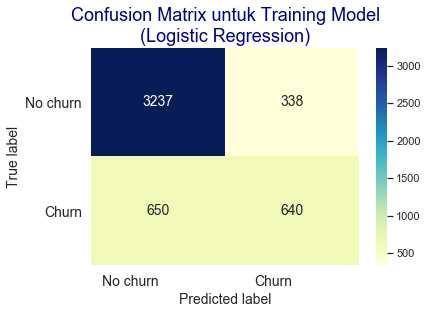

In [11]:
#Menampilkan hasil training model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [12]:
#Menampilkan hasil testing model dengan confusion matrix
# Predict
y_test_pred = log_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



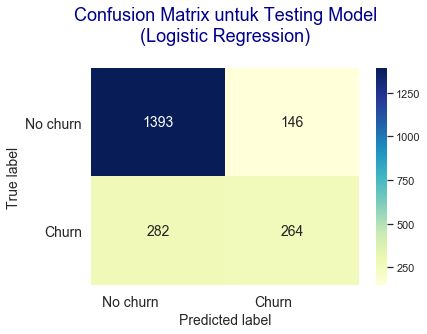

In [13]:
#Menampilkan hasil testing model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### b. Pemodelan dengan metode Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
#Latih model dengan RandomForestClassifier()
rdf_model = RandomForestClassifier().fit(x_train, y_train)
print(rdf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [15]:
#Menampilkan hasil training dengan confusion matrix
from sklearn.metrics import classification_report
# Predict
y_train_pred = rdf_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Random Forest) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       0.99      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       1.00      0.99      0.99      4865
weighted avg       1.00      1.00      1.00      4865



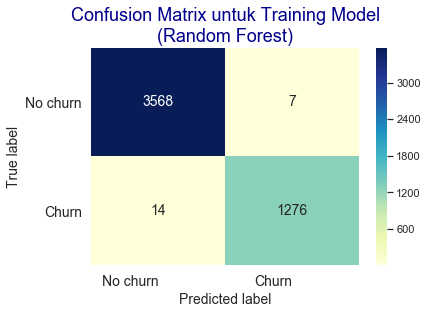

In [16]:
#Menampilkan hasil training model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [17]:
#Menampilkan hasil testing model dengan confusion matrix
# Predict
y_test_pred = rdf_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Random Forest):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1539
           1       0.59      0.47      0.53       546

    accuracy                           0.78      2085
   macro avg       0.71      0.68      0.69      2085
weighted avg       0.76      0.78      0.77      2085



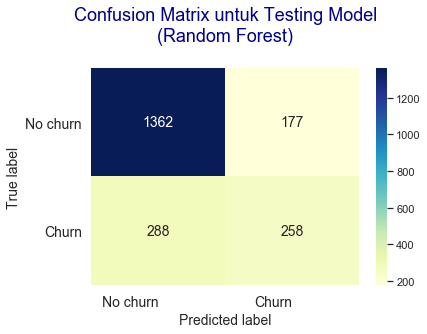

In [18]:
#Menampilkan hasil testing model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Testing Model\n(Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

#### c. Pemodelan dengan metode Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
#Latih model dengan GradientBoostingClassifier()
gbt_model = GradientBoostingClassifier().fit(x_train, y_train)
print(gbt_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [20]:
#Menampilkan hasil training dengan confusion matrix
from sklearn.metrics import classification_report
# Predict
y_train_pred = gbt_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Gradien Boosting) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Gradien Boosting) :
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3575
           1       0.70      0.53      0.60      1290

    accuracy                           0.82      4865
   macro avg       0.77      0.72      0.74      4865
weighted avg       0.81      0.82      0.81      4865



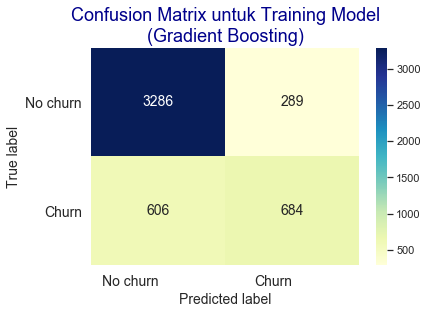

In [21]:
#Menampilkan hasil training model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Training Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [22]:
#Menampilkan hasil testing model dengan confusion matrix
# Predict
y_test_pred = gbt_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



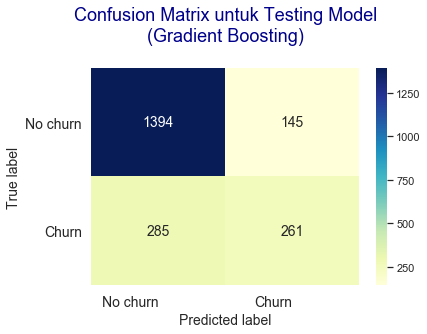

In [23]:
#Menampilkan hasil testing model dengan visualisasi heatmap dari confusion matrix 
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix untuk Testing Model\n(Gradient Boosting)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [24]:
#Save Model log_model (Logistic Regression) sebagai model terbaik
pickle.dump(log_model, open('best_model_churn.pkl', 'wb'))

In [25]:
print(log_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
